<a href="https://colab.research.google.com/github/markkod/pc3-enzymes/blob/exploratory_da/Kernels_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis
## Group 8
#### Graph Property Prediction



## Setup



Cloning the git repo, installing matching pytorch addons, building C++ bindings

In [3]:
# %%capture output

# Script to generate variations of the kernels yourself
# https://ucloud.univie.ac.at/index.php/s/E3YKph0jkpbw8TN


# #Download the TUDataset Repository with
!git clone https://github.com/chrsmrrs/tudataset.git
# #move this script to tudataset/tud_benchmark

# Make sure that the matching version of torch is used
import torch
version = torch.__version__.split('+')[0]

# #Install pytorch geometric: https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
# #Here is the gpu cuda installation, for the cpu version replace cu102 with cpu
%pip --no-cache-dir install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-{version}.html
%pip --no-cache-dir install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-{version}.html
%pip --no-cache-dir install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-{version}.html
%pip --no-cache-dir install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-{version}.html
%pip --no-cache-dir install torch-geometric

%pip --no-cache-dir install pybind11
!sudo apt-get install libeigen3-dev

%cd ..
%cd /content/tudataset/tud_benchmark/kernel_baselines/
! ls
! g++ -I /usr/include/eigen3 -O3 -shared -std=c++11 -fPIC `python3 -m pybind11 --includes`  kernel_baselines.cpp src/*cpp -o ../kernel_baselines`python3-config --extension-suffix`
%cd ..

fatal: destination path 'tudataset' already exists and is not an empty directory.
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 11.9MB 39.9MB/s 
  Found existing installation: torch-scatter 2.0.5
    Uninstalling torch-scatter-2.0.5:
      Successfully uninstalled torch-scatter-2.0.5
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 24.3MB 1.2MB/s 
  Found existing installation: torch-sparse 0.6.8
    Uninstalling torch-sparse-0.6.8:
      Successfully uninstalled torch-sparse-0.6.8
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 21.5MB 1.2MB/s 
  Found existing installation: torch-cluster 1.5.8
    Uninstalling torch-cluster-1.5.8:
      Successfully uninstalled torch-cluster-1.5.8
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 6.4MB 7.8MB/s 
 

Handling the imports

In [4]:
import os
import torch
import numpy as np
import kernel_baselines as kb
import auxiliarymethods
from auxiliarymethods import datasets as dp
from scipy.sparse import save_npz
from scipy.sparse import load_npz
from scipy.sparse import csr_matrix
from auxiliarymethods import auxiliary_methods as aux
from auxiliarymethods import kernel_evaluation as ke
from auxiliarymethods.reader import tud_to_networkx
from matplotlib import pyplot as plt
import networkx as nx
from collections import defaultdict
from pprint import pprint
import random
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

Utility methods for data loading and graph visualization



In [5]:
def setup_directory(dir_name: str, verbose=False):
    """Setup directory in case it does not exist.

    Args:
        dir_name (str): path + name to directory
        verbose (bool, optional): Indicates whether directory creation should be printed or not. Defaults to False.

    Raises:
        RuntimeError:
    """
    if not os.path.exists(dir_name):
        try:
            os.makedirs(dir_name)
            if verbose:
                print("Created Directory: {}".format(dir_name))
        except Exception as e:
            raise RuntimeError(
                "Could not create directory: {}\n {}".format(dir_name, e))


def load_csv(path: str):
    """Loads a csv file from a given path.

    Args:
        path (str): path

    Returns:
        ndarray: Data read from the text file.
    """
    return np.loadtxt(path, delimiter=";")


def load_sparse(path: str):
    """Loads a sparse matrix from a given npz file.

    Args:
        path (str): path to .npz file

    Returns:
        csc_matrix, csr_matrix, bsr_matrix, dia_matrix or coo_matrix: A sparse matrix containing the loaded data.
    """
    return load_npz(path)


def visualize(G, color=None, figsize=(5,5)):
    """Visualizes the given graph.

    Args:
        G (Graph): graph to be visualized
        color ([type], optional): color of the graph. Defaults to None.
        figsize (tuple, optional): Visualization size. Defaults to (5, 5).
    """
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, 
                     pos=nx.spring_layout(G, seed=42),
                     with_labels=True,
                     node_color=color,
                     cmap="Set2")
    plt.show()


def find_keys_with_condition(data: dict, cond: str) -> list:
    """Finds keys in a dictionary that contains the given condition. Keys 
    have to be strings.

    Args:
        data (dict): Dictionary to be searched
        cond (str): Condition string

    Returns:
        list: keys that match the condition
    """
    return list(filter(lambda x: cond in x, data.keys()))


def load_data() -> dict:
  """Loads the ENZYMES dataset.

    Returns:
        dict: dataset
    """
  result = {}
  extensions = ['csv', 'npz']
  types = ['gram_matrix', 'vectors']
  algos = ['wl1', 'wl2', 'wl3', 'wl4', 'wl5', 'wl6', 'wl7', 'wl8', 'shortestpath', 'graphlet']
  base_name = '/content/tudataset/tud_benchmark/kernels/node_labels/ENZYMES_{0}_{1}.{2}'

  for t, e in zip(types, extensions):
    result[t] = {}
    for a in algos:
      algo_name = 'wl' if 'wl' in a else a

      if algo_name not in result[t].keys():
        result[t][algo_name] = []

      file_name = base_name.format(t, a, e)

      if e == 'csv':
        f = np.loadtxt(file_name, delimiter=';')
      else:
        f = load_npz(file_name)
      
      result[t][algo_name].append(f)
  return result


Build the gram matrices and vector representations

In [6]:
def get_base_path(use_labels: bool) -> str:
    """Gets the base path for the kernels based on whether labels are used or not.

    Args:
        use_labels (bool): Whether to use labels or not.
    """
    if use_labels:
      return os.path.join("kernels","node_labels")
    else:
      return os.path.join("kernels","without_labels")

def build_wl(base_path: str, dataset: list, use_labels: bool, use_edge_labels: bool):
    """Builds the gram matrix and vector representations for the Weisfeiler-Lehman
    subtree kernel and saves them respectively as .csv and .npz files.

    Args:
        base_path (string): location where to save the file
        dataset ([Graph]): dataset
        use_labels (bool): indicates whether to use labels in the calculation
        use_edge_labels (bool): indicates whether to use edge labels in the calculation
    """
    print("Start computing Weisfeihler-Lehman gram matrix and vector representations")
    iterations = 9
    #0 taking just the nodelabels themselves into account; 
    #1 considers nearest-neighbours, 2 one layer deeper and so on
    for i in range(1, iterations):
        print("Start iteration ", i)
        #Gram Matrix for the Weisfeiler-Lehman subtree kernel
        gram_matrix_wl = kb.compute_wl_1_dense(dataset, i, use_labels, use_edge_labels)
        np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_wl{i}.csv"),
                gram_matrix_wl,
                delimiter=";")
        #Sparse Vectors for the Weisfeiler-Lehmann subtree kernel
        vectors_wl = kb.compute_wl_1_sparse(dataset, i, use_labels, use_edge_labels)
        save_npz(os.path.join(base_path,f"{dataset}_vectors_wl{i}.npz"),
                vectors_wl, compressed=True)


def build_graphlet(base_path: str, dataset: list, use_labels: bool, use_edge_labels: bool):
    """Builds the gram matrix and vector representations for the Graphlet
      kernel and saves them respectively as .csv and .npz files.

    Args:
        base_path (string): location where to save the file
        dataset ([Graph]): dataset
        use_labels (bool): indicates whether to use labels in the calculation
        use_edge_labels (bool): indicates whether to use edge labels in the calculation
    """
    print("Start computing Graphlet gram matrix")
    #Gram Matrix for the Graphlet kernel
    gram_matrix_graphlet= kb.compute_graphlet_dense(dataset, use_labels, use_edge_labels)
    np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_graphlet.csv"),
            gram_matrix_graphlet,
            delimiter=";")
    print("Start computing Graphlet vector representation")
    #Sparse Vectors for the Graphlet kernel
    vectors_graphlet = kb.compute_graphlet_sparse(dataset, use_labels, use_edge_labels)
    save_npz(os.path.join(base_path,f"{dataset}_vectors_graphlet.npz"),
            vectors_graphlet, compressed=True)


def build_shortest_path(base_path: str, dataset: list, use_labels: bool, use_edge_labels: bool):
    """Builds the gram matrix and vector representations for the Shortest path
      kernel and saves them respectively as .csv and .npz files.

    Args:
        base_path (string): location where to save the file
        dataset ([Graph]): dataset
        use_labels (bool): indicates whether to use labels in the calculation
        use_edge_labels (bool): indicates whether to use edge labels in the calculation
    """
    print("Start computing Shortest path gram matrix")

    #Gram Matrix for the Shortest path kernel
    gram_matrix_shortestpath = kb.compute_shortestpath_dense(dataset, use_labels)
    np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_shortestpath.csv"),
            gram_matrix_shortestpath,
            delimiter=";")
    print("Start computing Shortest path vector representation")
    #Sparse Vectors for the Shortest path kernel
    vectors_shortestpath = kb.compute_shortestpath_sparse(dataset, use_labels)
    save_npz(os.path.join(base_path,f"{dataset}_vectors_shortestpath.npz"),
            vectors_shortestpath, compressed=True)

def build_gram_matrix_and_vector_representations(use_edge_labels=False):
    """Builds gram matrix and vector represenations of the following
    kernels: Weisfeiler-Lehman, Graphlet, Shortest path and saves them to 
    respective files.

    Args:
        use_edge_labels (bool, optional): Whether to use the edge labels in the 
        calculation of the kernel represenations. Defaults to False.
    """
    for USE_LABELS in [True, False]:
        for dataset, use_labels in [["ENZYMES", USE_LABELS]]:
            base_path = get_base_path(use_labels)
            setup_directory(base_path)
            print("Start processing data set ", dataset)
            # Download dataset.
            classes = dp.get_dataset(dataset)
            # *Weisfeihler-Lehman*
            build_wl(base_path, dataset, use_labels, use_edge_labels)
            # *Graphlet kernel*
            build_graphlet(base_path, dataset, use_labels, use_edge_labels)
            # *Shortest path kernel*
            build_shortest_path(base_path, dataset, use_labels, use_edge_labels)


In [7]:
build_gram_matrix_and_vector_representations()

Start processing data set  ENZYMES
Start computing Weisfeihler-Lehman gram matrix and vector representations
Start iteration  1
Start iteration  2
Start iteration  3
Start iteration  4
Start iteration  5
Start iteration  6
Start iteration  7
Start iteration  8
Start computing Graphlet gram matrix
Start computing Graphlet vector representation
Start computing Shortest path gram matrix
Start computing Shortest path vector representation
Start processing data set  ENZYMES
Start computing Weisfeihler-Lehman gram matrix and vector representations
Start iteration  1
Start iteration  2
Start iteration  3
Start iteration  4
Start iteration  5
Start iteration  6
Start iteration  7
Start iteration  8
Start computing Graphlet gram matrix
Start computing Graphlet vector representation
Start computing Shortest path gram matrix
Start computing Shortest path vector representation


Loading the data and previewing the format

In [8]:
base_path = os.path.join("kernels", "node_labels")
ds_name = "ENZYMES"
classes = dp.get_dataset(ds_name)
G = tud_to_networkx(ds_name)
print(f"Number of graphs in data set is {len(G)}")
print(f"Number of classes {len(set(classes.tolist()))}")

Number of graphs in data set is 600
Number of classes 6


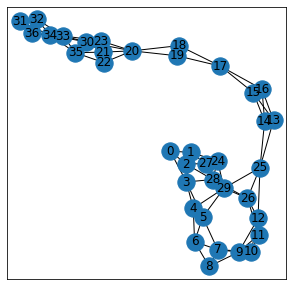

In [9]:
visualize(G[0])

Load the entire dataset of the gram matrices from the base kernels


In [10]:
data = load_data()

## Kernel evaluation

In [11]:
def eval_kernel(kernel, classes, mode, n_reps=10, all_std=True):
  """Evaluates a specific kernel that will be normalized before evaluation.

    Args:
        kernel ([list]): kernel
        classes (list): dataset classes
        mode (string): LINEAR | KERNEL
        n_reps (int, optional): Number of repetitions. Defaults to 10.
        all_std (bool, optional): Standard deviation?. Defaults to True.

    Returns:
        tuple: evaluation results
    """
  normalized = []
  print(f'Starting normalization of {len(kernel)} elements...')
  for array in kernel:
    if mode == 'LINEAR':
      normalized.append(aux.normalize_feature_vector(array))
    else:
      normalized.append(aux.normalize_gram_matrix(array))
  print(f'Normalization finished, starting {mode} SVM...')
  if mode == 'LINEAR':
    return ke.linear_svm_evaluation(normalized, classes, num_repetitions=n_reps, all_std=all_std)
  return ke.kernel_svm_evaluation(normalized, classes, num_repetitions=n_reps, all_std=all_std)


def eval_all(data):
  """Evaluates the kernels on the data.

    Args:
        data (dict): data

    Returns:
        dict: results of evaluations, data type -> kernel
    """
  classes = dp.get_dataset('ENZYMES')
  result = {}
  for data_type in data.keys():
    mode = 'LINEAR' if data_type == 'vectors' else 'KERNEL'
    result[data_type] = {}
    print('MODE:', mode)
    for kernel in data[data_type]:
      print(f'\nEvaluating {kernel} SVM...')
      result[data_type][kernel] = eval_kernel(data[data_type][kernel], classes, mode)
      print(f'{data_type}-{kernel} : {result[data_type][kernel]}')
  return result

### Baseline kernels

In [11]:
results = eval_all(data)

MODE: KERNEL

Evaluating wl SVM...
Starting normalization of 8 elements...
Normalization finished, starting KERNEL SVM...
gram_matrix-wl : (50.96666666666667, 0.9030811456096041, 6.579344783318304)

Evaluating shortestpath SVM...
Starting normalization of 1 elements...
Normalization finished, starting KERNEL SVM...
gram_matrix-shortestpath : (41.25, 1.464866319270579, 6.647367900154167)

Evaluating graphlet SVM...
Starting normalization of 1 elements...
Normalization finished, starting KERNEL SVM...
gram_matrix-graphlet : (29.48333333333333, 1.4934114562898528, 4.759172430393987)
MODE: LINEAR

Evaluating wl SVM...
Starting normalization of 8 elements...
Normalization finished, starting LINEAR SVM...
vectors-wl : (51.8, 1.4903392604072092, 6.449289366537474)

Evaluating shortestpath SVM...
Starting normalization of 1 elements...
Normalization finished, starting LINEAR SVM...
vectors-shortestpath : (40.56666666666666, 1.7984561280288278, 5.869980124895371)

Evaluating graphlet SVM...
Sta

In [12]:
def draw_graph(data1, std1, data2, std2, labels, title, ax_label):
  """
  Draws the bar chart based on data and its standard deviation.

  Args:
      data1 (list): dataset 1
      std1 (list): standard deviations of dataset 1
      data2 (list, optional): dataset 2. If present, then it will be displayed alongside data1.
      std2 (list, optional): standard deviations of dataset 2
      labels (list): labels for the graphs on X-axis
      title (str): title of the graph
      ax_label (str): label of the Y-axis

  """
  # https://matplotlib.org/examples/api/barchart_demo.html

  N = len(labels)
  ind = np.arange(N)  # the x locations for the groups
  width = 0.35       # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(ind, data1, width * 2 if data2 is None else width, color='r', yerr=std1)
  if data2 is not None:
    rects2 = ax.bar(ind + width, data2, width, color='y', yerr=std2)

  # add some text for labels, title and axes ticks
  ax.set_ylabel(ax_label)
  ax.set_title(title)
  ax.set_xticks(ind + width / 2)
  ax.set_xticklabels(labels)

  if data2 is not None:
    ax.legend((rects1[0], rects2[0]), ('Gram', 'Vector'))


  def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width() / 2.,
              1.05 * height,
              '%d' % int(height),
              ha='center', va='bottom')

  autolabel(rects1)
  if data2 is not None:
    autolabel(rects2)

  plt.show()

In [13]:
draw_graph(list(x[0] for x in results['gram_matrix'].values()),
           list(x[1] for x in results['gram_matrix'].values()),
           list(x[0] for x in results['vectors'].values()),
           list(x[1] for x in results['vectors'].values()),
           list(x for x in results['gram_matrix'].keys()),
           'Scores for kernels and modes',
           'Evaluation score')

NameError: ignored

From the results, it's obvious that the best results of all base kernels are achieved using the WL kernel in it's vector shape. We can now compare how does the number of iterations done affect the result

In [14]:
wl_results = []
for array in data["gram_matrix"]["wl"]:
 normalized = [aux.normalize_gram_matrix(array)]
 wl_results.append(ke.kernel_svm_evaluation(normalized, classes, num_repetitions=10, all_std=True))

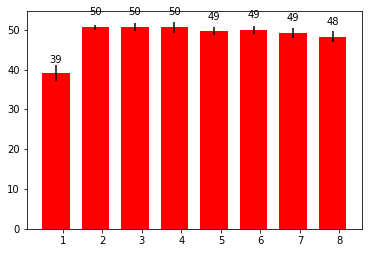

In [15]:
draw_graph(list(x[0] for x in wl_results), list(x[1] for x in wl_results), None, None, list(range(1, 9)), "", "")

As we can see, past a certain point, a number of *iterations* does not have a big effect on the final score. We setteled on using 2 iterations as that's the first time the highest value is achieved

#### Histogram kernel

Kernel based on a histogram of the number of nodes in the graph

In [16]:
# Maximum number of nodes in any of the graphs, used to allocate the vector size
max_nodes = max(map(lambda x: x.number_of_nodes(), G))

# Uses a sparse matrix since most elements will be 0, every vector will be 
# padded with zeros until the max size is reached
histograms = csr_matrix((len(G), max_nodes))
for i, g in enumerate(G):
    for n, d in g.degree():
        histograms[i, n] = d
        
# Create gram matrix from feature vectors
histogram_gram = histograms @ histograms.T

#### Centrality kernel

Kernel based on a the centrality value for each node in the graph

In [17]:
# Uses a sparse matrix since most elements will be 0, every vector will be 
# padded with zeros until the max size is reached
centrality = csr_matrix((len(G), max_nodes))
for i, g in enumerate(G):
    for n, d in nx.degree_centrality(g).items():
        centrality[i, n] = d

# Create gram matrix from feature vectors        
centrality_gram = centrality @ centrality.T

In [18]:
custom_results = []
for array in [histograms, centrality]:
 normalized = [aux.normalize_feature_vector(array)]
 custom_results.append(ke.linear_svm_evaluation(normalized, classes, num_repetitions=10, all_std=True))

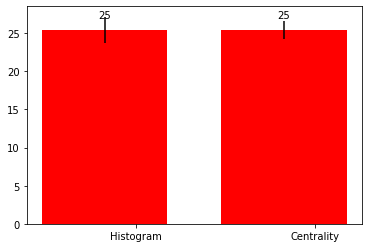

In [19]:
draw_graph(list(x[0] for x in custom_results), list(x[1] for x in custom_results), None, None, ["Histogram", "Centrality"], "", "")

In [20]:
val_wl_histo = data["vectors"]["wl"][2].T.dot(histograms)
normalized = [aux.normalize_feature_vector(val_wl_histo)]
wfl_histograms_res = ke.linear_svm_evaluation(normalized, classes, num_repetitions=10, all_std=True)
print(wfl_histograms_res)

(42457, 126)
(42457, 600)
(600, 126)
(69.58333333333331, 0.5880759588125751, 5.198156724583566)


In [21]:
val_wl_central = data["vectors"]["wl"][2].T.dot(centrality)
normalized = [aux.normalize_feature_vector(val_wl_central)]
wfl_centralized_res = ke.linear_svm_evaluation(normalized, classes, num_repetitions=10, all_std=True)
print(wfl_centralized_res)

(69.53333333333333, 0.7180219742846016, 5.297169055259612)


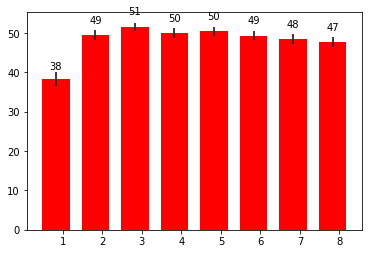

In [22]:
wl_results = []
for array in data["gram_matrix"]["wl"]:
 normalized = [aux.normalize_gram_matrix(array)]
 wl_results.append(ke.kernel_svm_evaluation(normalized, classes, num_repetitions=10, all_std=True))

draw_graph(list(x[0] for x in wl_results), list(x[1] for x in wl_results), None, None, list(range(1, 9)), "", "")

As we can see, past a certain point, a number of *iterations* does not have a big effect on the final score. We setteled on using 3 iterations for now but might revert this desicion if furhter evaluation states differently.

### Evaluation
In the following the conceptualized kernel will be evaluated according to scalability, accuracy and applicability.

#### Scalability

In [23]:
import random

def scalability_shuffle(step_size, variant_vec, wl_vec, G):
  subset_size = step_size
  shuffled_G = G
  
  random.shuffle(shuffled_G)

  index_value = random.sample(list(enumerate(shuffled_G)), 600)
  indexes = []
  values = []
  for idx, val in index_value:
    indexes.append(idx)
    values.append(val)

  wl_results_scalibility = []

  for i in range(int(600 / step_size)):
    tmp_val = wl_vec[indexes[:subset_size]].T.dot(variant_vec[indexes[:subset_size]])
    normalized_tmp = [aux.normalize_feature_vector(tmp_val)]
    tmp_result = ke.linear_svm_evaluation(normalized_tmp, classes, num_repetitions=10, all_std=True)
    print(tmp_result)
    wl_results_scalibility.append(tmp_result)
    print(subset_size)
    subset_size += step_size
  return wl_results_scalibility

In [24]:
scalibility_cen = scalability_shuffle(100, centrality, data["vectors"]["wl"][2], G)

(31.316666666666663, 0.41129875597510146, 5.396989901787848)
100
(32.18333333333333, 1.4709218575815333, 5.615924777907118)
200
(45.083333333333336, 1.0414999866645331, 5.913144491535598)
300
(45.13333333333333, 0.7333333333333338, 6.323149707402334)
400
(60.36666666666666, 0.6782329983125266, 5.570657252265858)
500
(69.58333333333334, 0.5737304826019479, 4.979820389442889)
600


In [25]:
scalibility_hist = scalability_shuffle(100, histograms, data["vectors"]["wl"][2], G)

(18.7, 0.8124038404635964, 4.481939064487354)
100
(49.916666666666664, 0.6112373606964098, 5.554652704415163)
200
(50.25000000000001, 0.49018137232842274, 6.417748826496719)
300
(56.28333333333334, 0.6954215348341687, 5.577011346192111)
400
(54.666666666666664, 0.6191391873668911, 5.421151989096864)
500
(69.38333333333333, 0.645712354260352, 5.475475626220369)
600



The scalibility of both kernels is present. It approves that the kernel doesn't suffer from having to handle more data and thus having not alleviating the course of dimensionality well enough. It compares several subset sizes of the entire graph database that needs to be shuffled prior, as the dataset was being presorted after vertice labels and size. Both kernels perform best when the most data is present with all 600 graphs. The Accuracy is the highest and means over the standard deviations are the lowest in both instances. Thus, the scalability of the respective kernels can be approved.

#### Accuracy

In [24]:
print("Vector Representations: ")
for res in results['vectors']:
      score = results['vectors'][res]
      print(f'{res}: {score}')

print("\nBare bone graph properties kernels: ")
for e in custom_results:
  print(e)

print("\nWFL combinations: \n")
print("Histograms: ")
print(wfl_histograms_res)
print("Vertice Centrality: ")
print(wfl_centralized_res)


Vector Representations: 
wl: (51.8, 1.4903392604072092, 6.449289366537474)
shortestpath: (40.56666666666666, 1.7984561280288278, 5.869980124895371)
graphlet: (30.1, 1.2342339054382407, 5.73401158778816)

Bare bone graph properties kernels: 
(25.65, 0.9293067906300436, 5.90148286450109)
(25.200000000000003, 1.142122779934122, 4.979290444765532)

WFL combinations: 

Histograms: 
(69.49999999999999, 0.9398581453247743, 5.469613027140646)
Vertice Centrality: 
(69.18333333333332, 0.9956851354162531, 5.23606616544223)


The accuracy evaluation has been done in many smaller steps by our side. Finding proper kernel properties and other kernels to combine to achieve our final custom kernel required iterative developmental steps, where desicions were made, implemented and evaluated to assess if current chosen options result in desired results.  
Firstly, we evaluated different provided kernels, like the shortest path, the WL and the graphlet kernel. As also stated in the lecture the WL kernel proved to be the most useful with an Accuracy of 51.25. Then, we decided that the iteration depth of 3 for the color refinement resulted in the best Accuracy score, which we chose to move on with.  
Further, we considered different properties to enhance our kernel by. We figured focusing on a vertex label histogram kernel would fit the task description well, as edge attributes should be omitted and the histogram kernel is benificiary for finding not only isomorphs according to the color refinement of the WL kernel, but additionally prior isomorphs, or at least strong similiarities, that were omitted during subiterations.  
Additionally, we found that using the degree of a vertice was fitting according to the domain of enzymes, as in our example the vertices are not only connected according to their physical connections, but to their closest 3 neighbors as well. Resulting in an image that represents closest compartments that pose as potential chemical attractors to each other. This complex composition of amino acids thus is a difficult to assess molecule. Additionally, not only the closest partners, but the direction the individual secondary structure elements are facing are relevant for predicting furhter structural levels of an enzyme.
Thus, we concluded using the degree of a node will result in a fitting property to extend our kernel with.  
Then, we tried out the bare bone kernels according to just the two properties that were just named, which resulted in comparably good results, with an Accuracy of 25.45 for the histograms and 25.53 for the node degree or as we described it centrality property. The standard deviations were expectedly high.  
Afterwards, we combined the properties with the Weisfeiler Lehmann Kernel and the results were quite good. Both performed better than the WL kernels' evaluations presented during the lecture. This might be due to the preprocessing done according to the spacial closeness property.  
The computed resulting Accuracies are 69.58 for the WL Histogram kernel and 70.18 for the WL Vertice Centrality kernel. Of course these results vary over the different iterations, but we managed to achieve consistently better results than for instance the WL shortest path kernel shown below. Further, the standard deviation turned out to be comparably low in both cases, which means that the classification can be confirmed with a higher certainty as the variability among the data gets lower. Meaning in a kernel context, that the projected Hilbert space of the individual graph's was better and is quite good to be able to more easily determine high dimensional features like the ones in the enzyme dataset.  
As, the results were quite satisfactory and the combination of both properties resulted in worse scores, we concluded that further attempted improvements, might remove dominance of either the single chosen property or the color refinement and thus will worsen result. Additionally, it is worth mentioning that when extending the WL shortest path kernel by either property, we achieved worse result than just utilizing the basic WL kernel. Other, attempted properties like finding maximal cliques, counting the amount of cliques or the size were not achieving satisfactory results. As other properties like vertex connectivity, in finding out maximal important compartments, are not applicable for the domain of enzymes, we concluded our improvement attempts.

In [37]:
wl_shortest = data["vectors"]["wl"][2].T.dot(data["vectors"]["shortestpath"][0])

normalized = [aux.normalize_feature_vector(wl_shortest)]
wfl_shortest_res = ke.linear_svm_evaluation(normalized, classes, num_repetitions=10, all_std=True)
print(wfl_shortest_res)

(68.25, 0.853912563829968, 5.813657292196635)


In [34]:
wl_intermediary = data["vectors"]["wl"][2].T.dot(histogram_gram)
wl_shortest_histo = wl_intermediary.dot(data["vectors"]["shortestpath"][0])

normalized = [aux.normalize_feature_vector(wl_shortest_histo)]
wfl_shortest_histo_res = ke.linear_svm_evaluation(normalized, classes, num_repetitions=10, all_std=True)
print(wfl_shortest_histo_res)

(48.88333333333334, 0.6584915421712805, 6.815240274561127)


In [35]:
wl_intermediary = data["vectors"]["wl"][2].T.dot(centrality_gram)
wl_shortest_cen = wl_intermediary.dot(data["vectors"]["shortestpath"][0])

normalized = [aux.normalize_feature_vector(wl_shortest_cen)]
wfl_shortest_cen_res = ke.linear_svm_evaluation(normalized, classes, num_repetitions=10, all_std=True)
print(wfl_shortest_cen_res)

(48.39999999999999, 0.3091206165165232, 6.1505193999278545)


#### Runtime
Assesing the runtime performance of a kernel would normally be done by by measuring the time it takes for either the feature map or the vectors representations of the kernel to be created. In this case this can hardly be assesed, as the WFL kernel is present as being precomputed and extension are being done by taking the dot product of the previous step with the newly created feature map according to some different property of the graph, in this case the histogram or the centrality. The number of operations to build up the individual feature maps is the same as building it up at once. There is even some optimization in not multiplying the individual vectors at creation, but at completion of the individual feature maps. Problem is that the individual evaluation steps and the final evaluation is being done with a linear SVM, thus the performance in that instance is rather bad. But as this doesn't belong to the runtime performance criteria of the kernel itself we consider it to be fine as it is.   
As many graphs of enzyme's are represented by sparse matrices and we are utilzing the histogram kernel as a shortest path kernel, one might be able to shorten the computational time required by applying the Dijsktra algorithm with Fibonacci heaps for finding the shortest paths more efficiently. Furhtermore, a breadth-first search could be applied to each vertice.  
